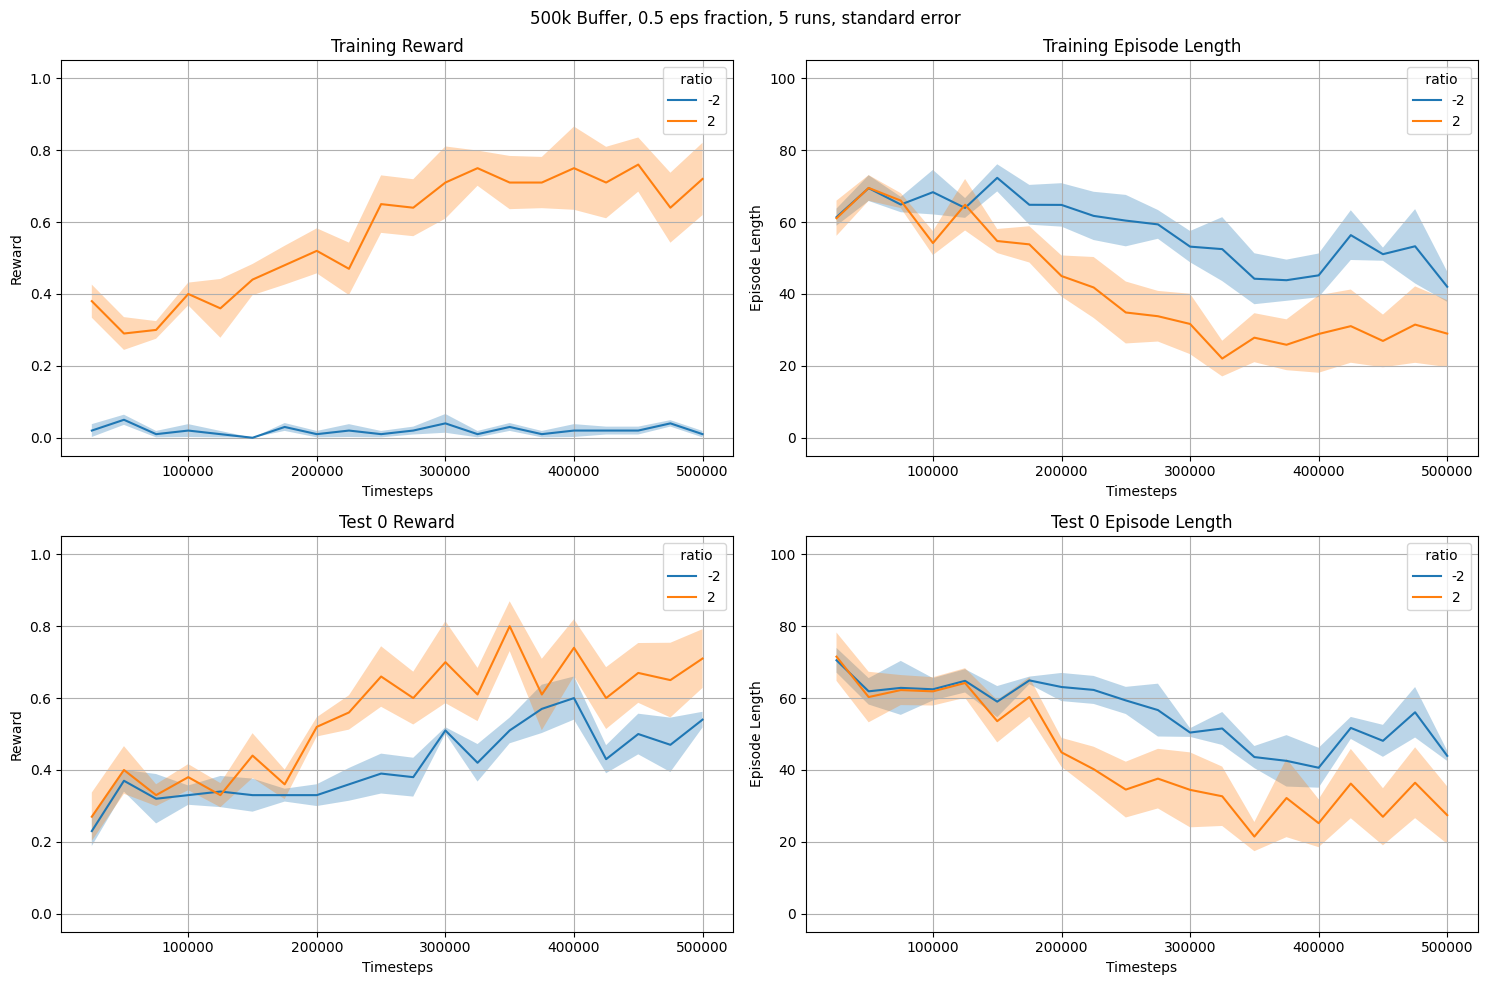

In [2]:
### Visualizing PURE UVF 

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=500 #in k
runs=5
start=0

random_walk_path=f'./logs/pure_uvf_b{buffersize}k'

def load_data(env, epsilon=1.0):
    tmp=[np.load(f"{random_walk_path}/{round(epsilon*100)}/{env}/{i}/evaluations.npz") for i in range(start,start+runs)]
    
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt

cmap=mpl.colormaps['tab20']

def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]
    labe=name

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
        pass
    else:
        ax.set_ylim(-5,105)

    mean=np.mean(data,axis=0)
    se=np.std(data,axis=0)/np.sqrt(data.shape[0])

    ax.plot(dt['timesteps'],mean, label=labe)
    ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title=' ratio')
    ax.grid(True)

fig, ax = plt.subplots(2,2, figsize=(15,10))

fig.suptitle(f"{buffersize}k Buffer, 0.5 eps fraction, {runs} runs, standard error")

for eps in [-2,2]:
    results={}

    for env in ['tr', '0', '100']:
        results[env]=load_data(env,eps)
    
    extra={}
    
    plot(ax[0,0],results['tr'], 'Training Reward',eps,'Reward','results', extra=extra)
    plot(ax[0,1],results['tr'], 'Training Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)

    # for pure uvf the test100 is basically the same as test training therefore skippable to make it easier to understand
    # plot(ax[1,0],results['100'], 'Test 100 Reward',eps,'Reward','results', extra=extra)
    # plot(ax[1,1],results['100'], 'Test 100 Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)

    plot(ax[1,0],results['0'], 'Test 0 Reward',eps,'Reward','results', extra=extra)
    plot(ax[1,1],results['0'], 'Test 0 Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)


plt.tight_layout()

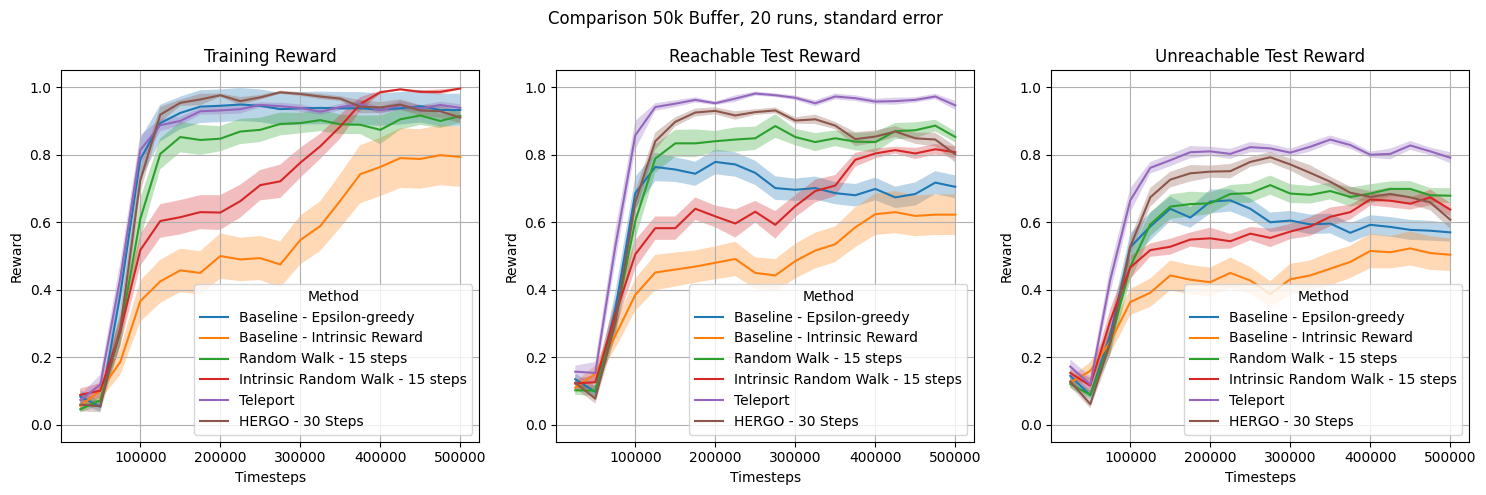

In [21]:
### Comparing Best of Categories

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np 

buffersize=50 #in k
runs=20
exp='main'
big=False

def load_data(env, name):
    tmp=[np.load(f"./logs/{name}_b{buffersize}k/{exp}_e100/{env}/{i}/evaluations.npz") for i in range(runs)]    


    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt

cmap=mpl.colormaps['tab20']
colors={}

legend_dict={
'base':'Baseline - Epsilon-greedy',
'rnd_base':'Baseline - Intrinsic Reward',
'hergo':'HERGO - 30 Steps',
'intrinsicRandomWalk':'Intrinsic Random Walk - 15 steps',
'randomStart':'Random Walk - 15 steps',
'tp':'Teleport',
}


def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]    

    labe=name

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
    else:
        ax.set_ylim(-5,105)

    mean=np.mean(data,axis=0)
    se=np.std(data,axis=0)/np.sqrt(data.shape[0])

    ax.plot(dt['timesteps'],mean, label=legend_dict[labe])
    ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title='Method', markerscale=100.0)
    ax.grid(True)

if big:
    fig, ax = plt.subplots(3,2, figsize=(15,15))
else:
    fig, ax = plt.subplots(1,3, figsize=(15,5))

fig.suptitle(f"Comparison {buffersize}k Buffer, {runs} runs, standard error")

for method in ['base','rnd_base','randomStart','intrinsicRandomWalk','tp','hergo']:
    eps=0.5
    results={}
    for env in ['tr', '0', '100']:
        results[env]=load_data(env,method)
    
    extra={}

    if big:    
        plot(ax[0,0],results['tr'], 'Training Reward',method,'Reward','results', extra=extra)
        plot(ax[0,1],results['tr'], 'Training Episode Length',method, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[1,0],results['100'], 'Reachable Test Reward',method,'Reward','results', extra=extra)
        plot(ax[1,1],results['100'], 'Reachable Test Episode Length',method, 'Episode Length','ep_lengths', extra=extra)

        plot(ax[2,0],results['0'], 'Unreachable Test Reward',method,'Reward','results', extra=extra)
        plot(ax[2,1],results['0'], 'Unreachable Test Length',method, 'Episode Length','ep_lengths', extra=extra)
    else:
        plot(ax[0],results['tr'], 'Training Reward',method,'Reward','results', extra=extra)
        plot(ax[1],results['100'], 'Reachable Test Reward',method,'Reward','results', extra=extra)
        plot(ax[2],results['0'], 'Unreachable Test Reward',method,'Reward','results', extra=extra)


plt.tight_layout()

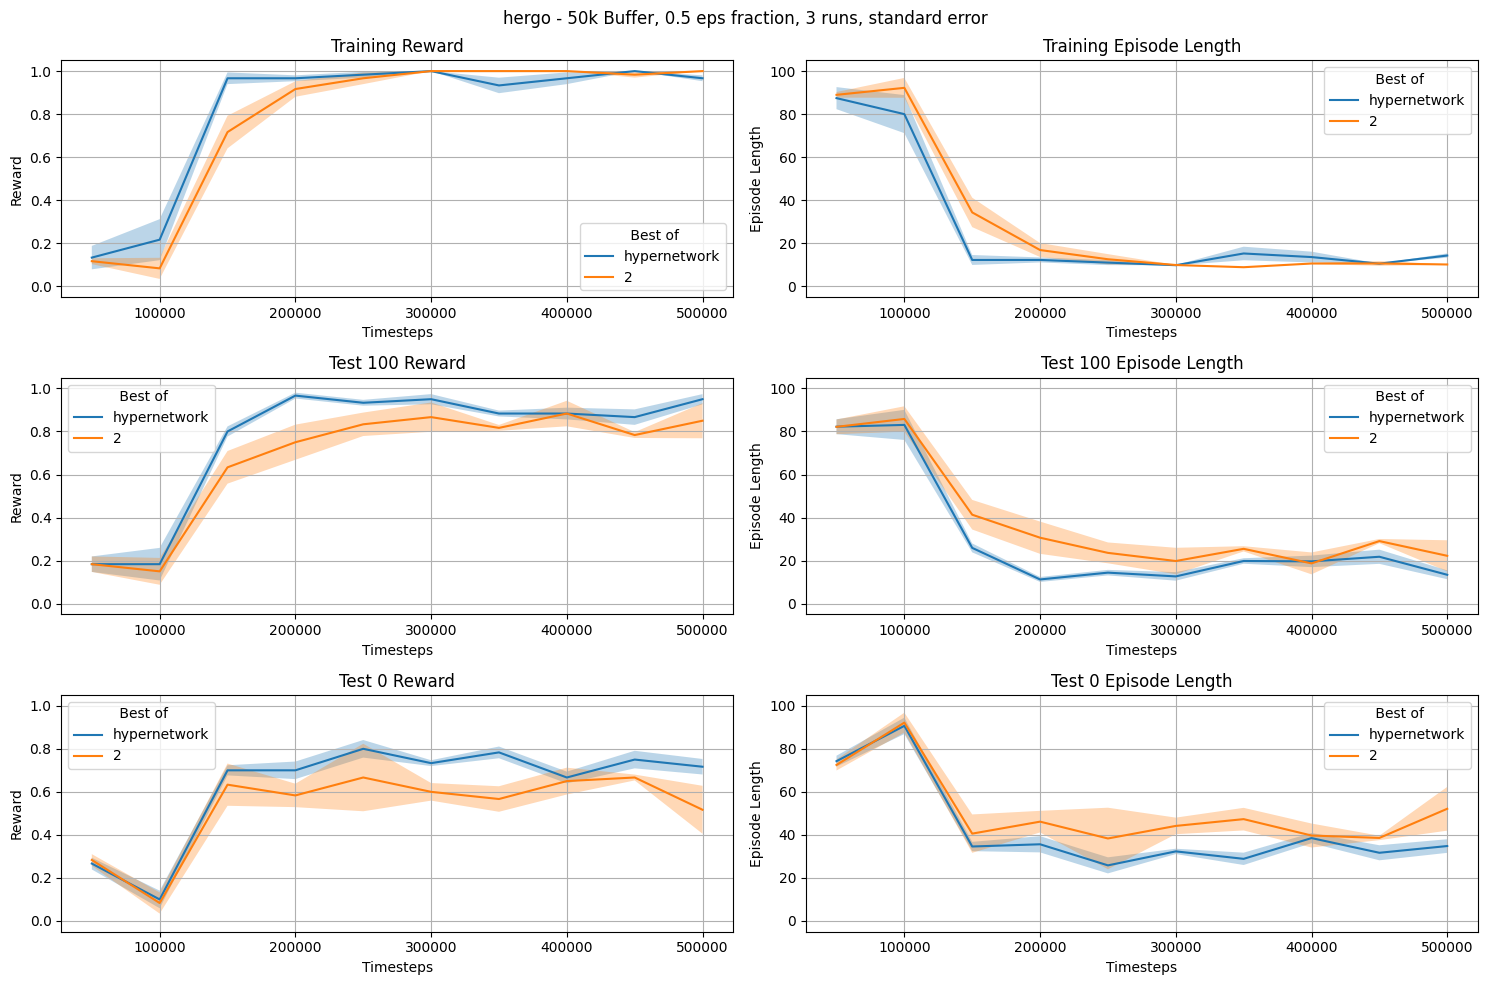

In [1]:
### GENERAL VIS

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 


buffersize=50
runs=3
start=0
method='hergo' # 'base','intrinsicRandomWalk','tp','hergo','randomStart','base_rnd'
experiment='hergoExtended'

random_walk_path=f'./logs/{method}_b{buffersize}k'

def load_data(env, epsilon=1.0):
    tmp=[np.load(f"./logs/{method}_b{buffersize}k/{experiment}_e{round(epsilon*100)}/{env}/{i}/evaluations.npz") for i in range(start,start+runs)]
    
    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt

cmap=mpl.colormaps['tab20']
eps_dict={0:'stack',1:'hypernetwork'}

def plot(ax, dt, title,name, ylabel, ydata, type='se', extra={}):
    data=dt[ydata]
    labe=name

    if ylabel=='Reward':
        ax.set_ylim(-0.05,1.05)
        pass
    else:
        ax.set_ylim(-5,105)

    mean=np.mean(data,axis=0)
    se=np.std(data,axis=0)/np.sqrt(data.shape[0])

    ax.plot(dt['timesteps'],mean, label=eps_dict[labe] if labe in eps_dict else labe)
    ax.fill_between(dt['timesteps'],mean-se,mean+se,alpha=0.3)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Timesteps')
    ax.legend(title=' Best of')
    ax.grid(True)

fig, ax = plt.subplots(3,2, figsize=(15,10))

fig.suptitle(f"{method} - {buffersize}k Buffer, 0.5 eps fraction, {runs} runs, standard error")

for eps in [1,2]:
    results={}

    for env in ['tr', '0', '100']:
        results[env]=load_data(env,eps)
    
    extra={}
    
    plot(ax[0,0],results['tr'], 'Training Reward',eps,'Reward','results', extra=extra)
    plot(ax[0,1],results['tr'], 'Training Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)

    plot(ax[1,0],results['100'], 'Test 100 Reward',eps,'Reward','results', extra=extra)
    plot(ax[1,1],results['100'], 'Test 100 Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)

    plot(ax[2,0],results['0'], 'Test 0 Reward',eps,'Reward','results', extra=extra)
    plot(ax[2,1],results['0'], 'Test 0 Episode Length',eps, 'Episode Length','ep_lengths', extra=extra)

plt.tight_layout()

In [5]:
### HEATMAP for starting pos
import matplotlib.pyplot as plt
from ipywidgets import widgets,  interactive, HBox, interactive_output
import numpy as np
import dill

methods=['intrinsicRandomWalk','hergo','randomStart']

name_dict={'hergo':'HERGO',
'intrinsicRandomWalk':'Intrinsic Exploration Walk',
'randomStart':'Random Walk'}



def load_data(buffersize, method, eps=""):
    return dill.load(open(f"./logs/startingPosData/{method}_start_pos_{buffersize}{eps if method=='intrinsicRandomWalk' else ''}.pl", "rb"))

context_list=load_data(500,'hergo').keys()

bs_w=widgets.Dropdown(
    options=[50, 500],
    value=500,
    description='Buffersize:',
    disabled=False,
)
context_w=widgets.Dropdown(options=context_list, description='Context:', disabled=False)

eps_w=widgets.Dropdown(
    options=["","_3","_4"],
    value="",
    description='Attendum:',
    disabled=False,
)
context_w=widgets.Dropdown(options=context_list, description='Context:', disabled=False)

def make_heatmap(ax, data, context):
    hm=np.zeros((9,9))
    for i in data:
        hm[i[0],i[1]]+=1
    print(np.sum(hm))
    goal=[int(i.strip()) for i in context[1:-1].split(',')][:2]
    hm=np.maximum(hm,5)
    ax.imshow(hm, cmap='magma', interpolation='nearest')
    ax.text(goal[0],goal[1],"G",color="white")

def make_all_heatmaps(bs,context,eps=""):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(f"Starting Position Heatmaps - {context} - {bs}k Buffer")
    for i,method in enumerate(methods):
        data=load_data(bs,method,eps)
        make_heatmap(ax[i], data[context], context)
        ax[i].set_title(f"{name_dict[method]}")

interactive_plot = interactive_output(make_all_heatmaps, {"bs":bs_w, "context":context_w, "eps":eps_w})

display(HBox([bs_w,context_w,eps_w]),interactive_plot)

Output()

Text(0.5, 0, 'Max Steps')

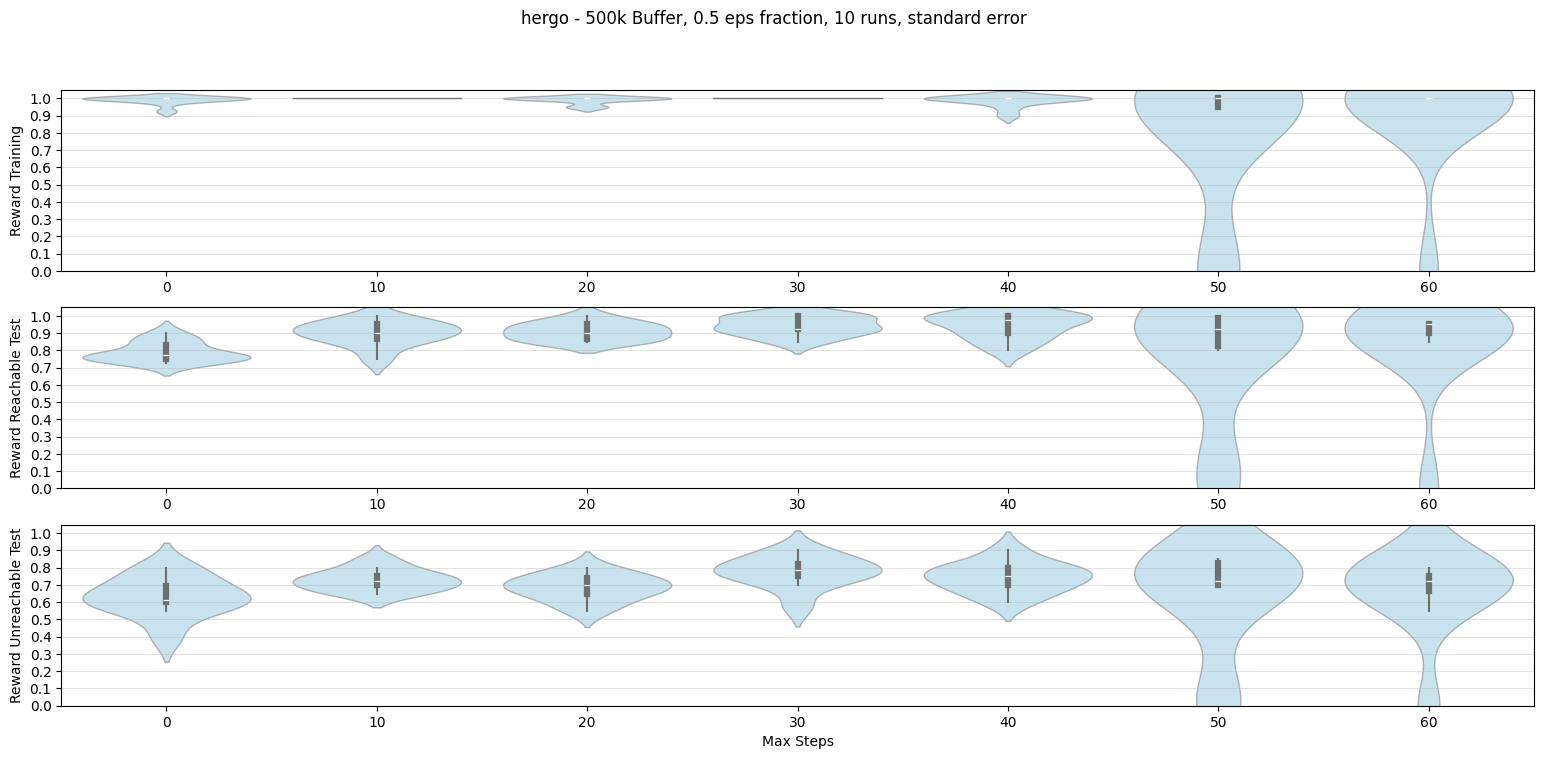

In [8]:
## Bar chart comparing final results of different parameters for w/e method (generalized)

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np 
import seaborn as sns

buffersize=500 #in k
runs=10
start=0
method='hergo' # 'base','intrinsicRandomWalk','tp','hergo','randomStart','base_rnd'
experiment='hyperHergo'
values=[0,10,20,30,40,50,60]
valuesLength=len(values)
namedict={'tr':'Training','0':'Unreachable Test','100':'Reachable Test'}

def load_data(env, epsilon=1.0):
    if epsilon==0:
        tmp=[np.load(f"./logs/base_b{buffersize}k/main_e100/{env}/{i}/evaluations.npz") for i in range(start,runs+start)]
    elif epsilon==30:
        tmp=[np.load(f"./logs/{method}_b{buffersize}k/main_e100/{env}/{i}/evaluations.npz") for i in range(start,runs+start)]
    else:
        tmp=[np.load(f"./logs/{method}_b{buffersize}k/{experiment}_e{round(epsilon*100)}/{env}/{i}/evaluations.npz") for i in range(start,runs+start)]

    dt={}
    dt['results']=np.array([np.mean(i['results'],axis=1) for i in tmp])
    dt['ep_lengths']=np.array([np.mean(i['ep_lengths'],axis=1) for i in tmp])
    dt['timesteps']=tmp[0]['timesteps']
    return dt

results={}

for val in values:
    results[val]={}
    for env in ['tr', '0', '100']:
        results[val][env]=load_data(env,val)

fig, ax = plt.subplots(3,1, figsize=(5+(2*valuesLength),8))

fig.suptitle(f"{method} - {buffersize}k Buffer, 0.5 eps fraction, {runs} runs, standard error")

for i,env in enumerate(['tr', '100', '0']):
    ax[i].set_ylabel(f'Reward {env}')

    for val in values:
        data=[]
        for run in range(runs):
            data.append(results[val][env]['results'][run][-1])
        sns.violinplot(x=val, y=data, ax=ax[i], color='skyblue', alpha=0.5, linewidth=1)
        #ax[i].bar(val,np.mean(data),yerr=np.std(data)/np.sqrt(runs), capsize=5, edgecolor='black',label=f'{val} steps')
    ax[i].set_ylim(0.00,1.05)
    ax[i].set_ylabel(f'Reward {namedict[env]}')
    ax[i].set_yticks([i/10 for i in range(0,11)])
    ax[i].set_xticks(range(valuesLength))
    ax[i].set_xticklabels([f'{v}' for v in values])

    ax[i].grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5, zorder=-1)
ax[2].set_xlabel('Max Steps')

